<a href="https://colab.research.google.com/github/nkilaru213/ai-excercises/blob/main/NaveenKilaru_MIMIC_Data_MLDL_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load Data MIMIC health data tables**

In [1]:
# import all the packages needed
import pandas as pd
from google.colab import files
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import joblib
import warnings
warnings.filterwarnings("ignore")



In [2]:
# Connect the the drive to access the google drive file system
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load tables

# Read ADMISSIONS data table from google drive file system
admissions=pd.read_csv('/content/drive/My Drive/Exercises/ADMISSIONS.csv')

# Read PATIENTS data table from google drive file system
patients=pd.read_csv('/content/drive/My Drive/Exercises/PATIENTS.csv')

# Read PRESCRIPTIONS data table from google drive file system
prescriptions=pd.read_csv('/content/drive/My Drive/Exercises/PRESCRIPTIONS.csv')

# Read ICU_STAYS data table from google drive file system
icustays=pd.read_csv('/content/drive/My Drive/Exercises/ICUSTAYS.csv')

# Read TRANSFERS data table from google drive file system
transfers=pd.read_csv('/content/drive/My Drive/Exercises/TRANSFERS.csv')

# Display ADMISSIONS table info
admissions.columns = map(lambda x: str(x).upper(), admissions.columns)
admissions.info()

# Display PATIENTS table info
patients.columns = map(lambda x: str(x).upper(), patients.columns)
patients.info()

# Display PRESCRIPTIOSN table info
prescriptions.columns = map(lambda x: str(x).upper(), prescriptions.columns)
prescriptions.info()

# Display ICUSTAYS table info
icustays.columns = map(lambda x: str(x).upper(), icustays.columns)
icustays.info()

# Display TRANSFERS table info
transfers.columns = map(lambda x: str(x).upper(), transfers.columns)
transfers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ROW_ID                129 non-null    int64 
 1   SUBJECT_ID            129 non-null    int64 
 2   HADM_ID               129 non-null    int64 
 3   ADMITTIME             129 non-null    object
 4   DISCHTIME             129 non-null    object
 5   DEATHTIME             40 non-null     object
 6   ADMISSION_TYPE        129 non-null    object
 7   ADMISSION_LOCATION    129 non-null    object
 8   DISCHARGE_LOCATION    129 non-null    object
 9   INSURANCE             129 non-null    object
 10  LANGUAGE              81 non-null     object
 11  RELIGION              128 non-null    object
 12  MARITAL_STATUS        113 non-null    object
 13  ETHNICITY             129 non-null    object
 14  EDREGTIME             92 non-null     object
 15  EDOUTTIME             92 non-null     ob

***Tables***

**admissions**  : Stores patient hospital admission details (time of admission, type, location, insurance, diagnosis, etc.)

**patients** : Contains demographic details (gender, birth date, death date, expiration flag).

**prescriptions** : Contains medication details (drug type, dosage, route, start & end dates).

**icustays** : Stores ICU admissions (care units, length of stay, entry/exit times).

**transfers** : Records patient movements between hospital units (previous/current ward).



In [4]:
# Display few rows from each dataframe
admissions.head()
patients.head()
prescriptions.head()
icustays.head()
transfers.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,EVENTTYPE,PREV_CAREUNIT,CURR_CAREUNIT,PREV_WARDID,CURR_WARDID,INTIME,OUTTIME,LOS
0,54440,10006,142345,206504.0,carevue,admit,NaN,MICU,NaN,52.0,2164-10-23 21:10:15,2164-10-25 12:21:07,39.18
1,54441,10006,142345,NaN,carevue,transfer,MICU,NaN,52.0,45.0,2164-10-25 12:21:07,2164-11-01 17:14:27,172.89
2,54442,10006,142345,NaN,carevue,discharge,NaN,NaN,45.0,NaN,2164-11-01 17:14:27,NaN,NaN
3,54460,10011,105331,232110.0,carevue,admit,NaN,MICU,NaN,15.0,2126-08-14 22:34:00,2126-08-28 18:59:00,332.42
4,54461,10011,105331,NaN,carevue,discharge,MICU,NaN,15.0,NaN,2126-08-28 18:59:00,NaN,NaN


# **Join or Merge Data**

In [5]:
# Convert datetime columns to pandas datetime objects for consistent time manipulation
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
patients['DOB'] = pd.to_datetime(patients['DOB'])
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])
transfers['INTIME'] = pd.to_datetime(transfers['INTIME'])
prescriptions['STARTDATE'] = pd.to_datetime(prescriptions['STARTDATE'], errors='coerce')  # errors='coerce' handles invalid dates

# Merge ADMISSIONS and PATIENTS to combine demographic and hospital stay data
adm_demo = admissions.merge(patients, on='SUBJECT_ID')

# Calculate patient's age at the time of admission (ADMITTIME - DOB), then convert to integer
adm_demo['AGE'] = adm_demo.apply(lambda row: (row['ADMITTIME'].to_pydatetime() - row['DOB'].to_pydatetime()).days / 365.25, axis=1)
adm_demo['AGE'] = adm_demo['AGE'].astype(int)

# Keep only relevant columns for modeling
adm_demo = adm_demo[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'AGE', 'GENDER']]

# Prepare ICU stay info and compute EARLY_ICU label
icu_early = icustays.copy()
icu_early = icu_early.merge(admissions[['HADM_ID', 'ADMITTIME']], on='HADM_ID')

# Create binary label: 1 if patient entered ICU within 24 hours of hospital admission
icu_early['EARLY_ICU'] = (icu_early['INTIME'] - icu_early['ADMITTIME']).dt.total_seconds() < 86400
icu_early = icu_early[['HADM_ID', 'EARLY_ICU']].drop_duplicates()

# Merge prescription data with admissions to compare drug start times to admission time
# Use suffixes to avoid column name conflicts
prescriptions = prescriptions.merge(admissions[['HADM_ID', 'ADMITTIME']], on='HADM_ID', how='left', suffixes=('', '_admission'))

# Calculate time difference between prescription start and admission (in seconds)
prescriptions['TIME_DIFF'] = (prescriptions['STARTDATE'] - prescriptions['ADMITTIME']).dt.total_seconds()

# Drop rows where STARTDATE or ADMITTIME was missing
prescriptions = prescriptions.dropna(subset=['TIME_DIFF'])

# Keep only prescriptions administered in the first 12 hours (43200 seconds)
prescriptions = prescriptions[prescriptions['TIME_DIFF'].between(0, 43200)]

# Count how many drugs were given in the first 12 hours per hospital stay
prescription_counts = prescriptions.groupby('HADM_ID')['DRUG'].count().reset_index(name='DRUG_COUNT')

# Get first recorded care unit transfer for each HADM_ID
first_transfer = transfers.sort_values(by='INTIME').drop_duplicates('HADM_ID')
first_transfer = first_transfer[['HADM_ID', 'CURR_CAREUNIT']]

# Merge all features into a single DataFrame
df = adm_demo.merge(icu_early, on='HADM_ID', how='left')
df = df.merge(prescription_counts, on='HADM_ID', how='left')
df = df.merge(first_transfer, on='HADM_ID', how='left')

# Fill missing values: patients not sent to ICU get EARLY_ICU=0, and DRUG_COUNT=0 if no early meds
df['EARLY_ICU'] = df['EARLY_ICU'].fillna(False).astype(int)
df['DRUG_COUNT'] = df['DRUG_COUNT'].fillna(0)

# Convert gender to binary (1 for female, 0 for male)
df['GENDER'] = (df['GENDER'] == 'F').astype(int)

# **Preprocessing**



In [6]:
# Select input features for modeling:
# - AGE: patient age at admission
# - GENDER: binary (1 for female, 0 for male)
# - DRUG_COUNT: number of drugs prescribed within 12h
# - CURR_CAREUNIT: initial care unit (categorical)
X = df[['AGE', 'GENDER', 'DRUG_COUNT', 'CURR_CAREUNIT']]

# Convert 'CURR_CAREUNIT' categorical column to one-hot encoding
# drop_first=True avoids multicollinearity by dropping the first category
X = pd.get_dummies(X, columns=['CURR_CAREUNIT'], drop_first=True)

# Define the target variable: whether patient was transferred to ICU within 24h
y = df['EARLY_ICU']

# Split data into training and testing sets with stratified sampling on the target
# This ensures class balance is preserved between splits
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Standardize the input features to have zero mean and unit variance
# This improves convergence for many ML algorithms, especially neural networks
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# **Machine Learning Model**


In [7]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
print("\nRandom Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print("AUC-ROC:", roc_auc_score(y_test, rf.predict_proba(X_test_scaled)[:, 1]))
joblib.dump(rf, "rf_icu_transfer_model.pkl")



Random Forest Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.83      0.87      0.85        23

    accuracy                           0.74        27
   macro avg       0.42      0.43      0.43        27
weighted avg       0.71      0.74      0.72        27

AUC-ROC: 0.4402173913043478


['rf_icu_transfer_model.pkl']

# **Deep Learning Model**


In [8]:
# Use a Neural Network to improve accuracy.

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)


In [9]:
class ICUTransferNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.fc(x)

model = ICUTransferNet(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    epoch_loss = 0
    for xb, yb in train_dl:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")


Epoch 1, Loss: 3.0602
Epoch 2, Loss: 3.0177
Epoch 3, Loss: 2.9748
Epoch 4, Loss: 2.9154
Epoch 5, Loss: 2.9106
Epoch 6, Loss: 2.9002
Epoch 7, Loss: 2.8524
Epoch 8, Loss: 2.8142
Epoch 9, Loss: 2.8035
Epoch 10, Loss: 2.7530


# **Evaluate Model Performance**


In [10]:
model.eval()
y_pred_dl = model(X_test_tensor).detach().numpy()
y_label_dl = (y_pred_dl > 0.5).astype(int)

print("\nDeep Learning Model Performance:")
print(classification_report(y_test, y_label_dl))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_dl))



Deep Learning Model Performance:
              precision    recall  f1-score   support

           0       0.12      0.25      0.17         4
           1       0.84      0.70      0.76        23

    accuracy                           0.63        27
   macro avg       0.48      0.47      0.46        27
weighted avg       0.74      0.63      0.67        27

AUC-ROC: 0.5543478260869565


# **Data Visulaization**

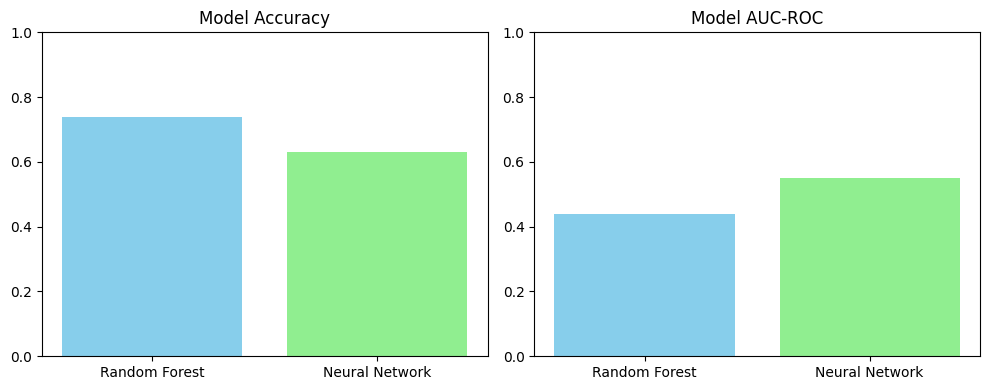

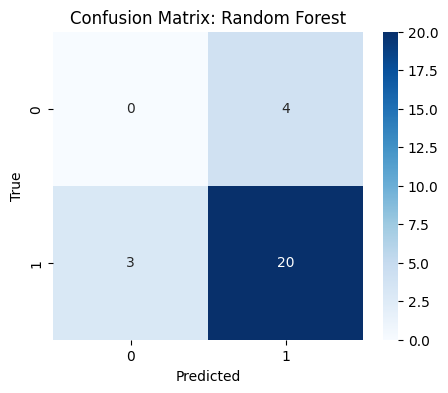

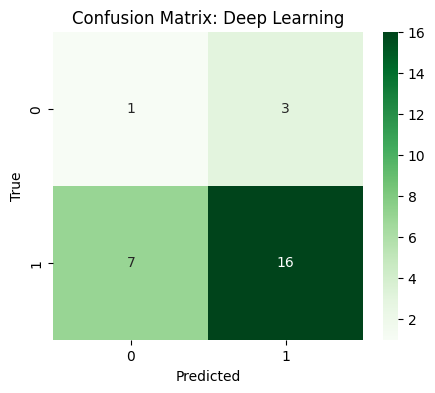

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Accuracy & AUC comparison
ml_auc = 0.44  # From your result
dl_auc = 0.55  # From your result

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Accuracy Bar
ax[0].bar(['Random Forest', 'Neural Network'], [0.74, 0.63], color=['skyblue', 'lightgreen'])
ax[0].set_title("Model Accuracy")
ax[0].set_ylim(0, 1)

# AUC Bar
ax[1].bar(['Random Forest', 'Neural Network'], [ml_auc, dl_auc], color=['skyblue', 'lightgreen'])
ax[1].set_title("Model AUC-ROC")
ax[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Confusion Matrix - Random Forest
rf_cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5, 4))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Confusion Matrix - Deep Learning
dl_cm = confusion_matrix(y_test, y_label_dl)
plt.figure(figsize=(5, 4))
sns.heatmap(dl_cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix: Deep Learning")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()